# Connect to Railway from Notebook



## Import Libraries

In [37]:
import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
from datetime import datetime
from sqlalchemy import text
import streamlit as st


# Import data

In [2]:
ft_btc_articles_df = pd.read_csv("ft_btc.csv")
# api_btc_df = pd.read_csv("alphavantage_api_btc.csv")
api_all_crypto = pd.read_csv ("alphavantage_all_crypto.csv")
ft_all_crypto_df = pd.read_csv("ft_all_crypto.csv")

In [3]:
ft_all_crypto_df.head()

,Unnamed: 0,title,link,snippet,date,symbol
0,0,Trump goes for shock therapy,https://www.ft.comhttps://www.ft.com/content/f...,The market was far too optimistic,2025-04-03,BTC
1,1,Bitcoin pares losses after sharp fall,https://www.ft.com/content/8c8062e5-2744-40ea-...,Bitcoin has recovered some ground after sharpl...,NaN,BTC
2,2,Gold surges to record high as investors seek s...,https://www.ft.com/content/8c8062e5-2744-40ea-...,Gold rose to a new record high as Donald Trump...,NaN,BTC
3,3,"Bitcoin falls below $85,000 after tariffs anno...",https://www.ft.com/content/8c8062e5-2744-40ea-...,The price of bitcoin sharply fell after Donald...,NaN,BTC
4,4,Stablecoin operator Circle files for IPO as re...,https://www.ft.comhttps://www.ft.com/content/7...,US firm is latest crypto group to try to take ...,2025-04-02,BTC


In [7]:
# checking for null values
ft_btc_articles_df.isna().sum()
# ft_btc_articles_df = ft_btc_articles_df.drop(columns="Unnamed: 0")
ft_all_crypto_df = ft_all_crypto_df.drop(columns="Unnamed: 0")

In [14]:
## clean article function

import pandas as pd

def clean_articles_df(df):
    """
    Cleans article DataFrame before inserting into SQL:
    - Converts 'date' to datetime
    - Replaces NaT with None for SQL compatibility
    - Drops rows with missing essential fields (title or link)
    """
    # Convert 'date' to datetime and coerce invalid values
    df["date"] = pd.to_datetime(df["date"])

    # Replace NaT with None for SQL compatibility
    df["date"] = df["date"].apply(lambda x: x.to_pydatetime().date() if pd.notnull(x) else None)

    # Drop rows with missing title or link
    df = df.dropna(subset=["title", "link"])

    return df


In [15]:
ft_all_crypto_df = clean_articles_df(ft_all_crypto_df)

In [131]:
# casting datecolumns to date time type
# ft_btc_articles_df["date"] = pd.to_datetime(ft_btc_articles_df["date"], dayfirst=True)
# ft_btc_df['date_formatted'] = ft_btc_df['date'].dt.strftime('%d-%m-%Y')
# api_btc_df["date"] =  pd.to_datetime(api_btc_df["date"])
api_all_crypto["date"] =  pd.to_datetime(api_all_crypto["date"])

## Create Connection

In [46]:
load_dotenv()
dbconn = os.getenv("DBCONN")


In [47]:
#connectino string
connection_string = dbconn

# Create SQLAlchemy engine
engine = create_engine(connection_string)


## Creating SQL Tables

#NOTE - droping the first table since it was only for btc

In [24]:
from sqlalchemy import text

def create_table(engine):
    with engine.begin() as conn:
        # print("Dropping api_data...")
        # conn.execute(text("DROP TABLE IF EXISTS api_data;"))

        print("Creating api_crypto_data...")
        conn.execute(text("""
            CREATE TABLE IF NOT EXISTS public.api_crypto_data (
                date DATE NOT NULL,
                symbol TEXT NOT NULL,
                open DOUBLE PRECISION,
                high DOUBLE PRECISION,
                low DOUBLE PRECISION,
                close DOUBLE PRECISION,
                volume DOUBLE PRECISION,
                PRIMARY KEY (date, symbol)
            );
        """))

        print("Ensuring ft_articles exists...")
        conn.execute(text("""
            CREATE TABLE IF NOT EXISTS public.ft_articles (
                id SERIAL PRIMARY KEY,
                title TEXT,
                link TEXT,
                snippet TEXT,
                date DATE
            );
        """))

        print("Ensuring ft_all_crypto_articles exists...")
        conn.execute(text("""
            CREATE TABLE IF NOT EXISTS public.ft_all_crypto_articles (
                id SERIAL PRIMARY KEY,
                symbol TEXT NOT NULL,
                title TEXT,
                link TEXT,
                snippet TEXT,
                date DATE
                
                          
            );
        """))

In [25]:
create_table(engine)

Creating api_crypto_data...
Ensuring ft_articles exists...
Ensuring ft_all_crypto_articles exists...


# Bulk insert with conflict handling

### inserting api data

In [4]:
from sqlalchemy import text

def insert_crypto_data(engine, df):
    """
    Insert rows from a crypto DataFrame into the api_data table,
    skipping duplicates (based on date + symbol).
    """
    insert_sql = text("""
        INSERT INTO api_crypto_data (date, symbol, open, high, low, close, volume)
        VALUES (:date, :symbol, :open, :high, :low, :close, :volume)
        ON CONFLICT (date, symbol) DO NOTHING;
    """)

    records = df.to_dict(orient="records")

    with engine.begin() as conn:
        conn.execute(insert_sql, records)
        print(f"✅ Inserted {len(records)} rows (skipping any duplicates).")


In [51]:
insert_crypto_data(engine, api_all_crypto)

NameError: name 'insert_crypto_data' is not defined

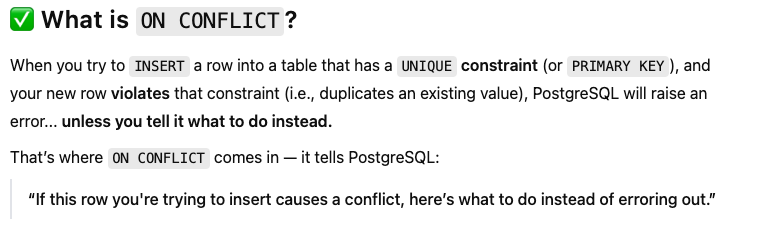

### add unique constraint to link

In [33]:
from sqlalchemy import text

def add_unique_constraint_to_articles(engine):
    with engine.begin() as conn:
        conn.execute(text("""
            ALTER TABLE ft_articles
            ADD CONSTRAINT unique_link UNIQUE (link);
        """))
        print("✅ Added unique constraint to ft_articles.link")


In [34]:
from sqlalchemy import text

def add_unique_constraint_to_all_articles(engine):
    with engine.begin() as conn:
        conn.execute(text("""
            ALTER TABLE ft_all_crypto_articles
            ADD CONSTRAINT unique_link_2 UNIQUE (link);
        """))
        print("✅ Added unique constraint to ft_all_crypto_articles.link")

In [35]:
add_unique_constraint_to_all_articles(engine)


✅ Added unique constraint to ft_all_crypto_articles.link


### inserting articles data

In [ ]:
def insert_ft_articles(engine, df):
    insert_sql = text("""
        INSERT INTO ft_articles (title, link, snippet, date)
        VALUES (:title, :link, :snippet, :date)
        ON CONFLICT (link) DO NOTHING;  
    """)

    records = df.to_dict(orient="records")

    with engine.begin() as conn:
        conn.execute(insert_sql, records)
        print(f"✅ Inserted {len(records)} articles.")


In [29]:
def insert_ft_all_crypto_articles(engine, df):
    insert_sql = text("""
        INSERT INTO ft_all_crypto_articles (title, symbol, link, snippet, date)
        VALUES (:title, :symbol, :link, :snippet, :date)
        ON CONFLICT (link) DO NOTHING;  
    """)

    records = df.to_dict(orient="records")

    with engine.begin() as conn:
        conn.execute(insert_sql, records)
        print(f"✅ Inserted {len(records)} articles.")

In [27]:
ft_btc_articles_df["date"] = ft_btc_articles_df["date"].apply(lambda x: x if pd.notnull(x) else None)
ft_all_crypto_df["date"] = ft_all_crypto_df["date"].apply(lambda x: x if pd.notnull(x) else None)


In [132]:
insert_ft_articles(engine, ft_btc_articles_df)

✅ Inserted 250 articles.


In [36]:
insert_ft_all_crypto_articles(engine, ft_all_crypto_df)

✅ Inserted 955 articles.


## Store DFs

In [ ]:
# Not as safe, it doesn't distinguish primary keys and constraints

# # populating articles table
# ft_btc_articles_df.to_sql("ft_articles", con=engine, if_exists="append", index = False)
# # populating api data table
# # api_btc_df.to_sql("api_data", con=engine, if_exists="append", index = False)
# api_all_crypto.to_sql("api_crypto_data", con=engine, if_exists="append", index = False)



750

pandas.to_sql(..., if_exists="append") is trying to insert into a table that already exists — and it's relying on SQLAlchemy to know the table schema.

However, SQLAlchemy is not aware of your table schema unless it created the table itself. Since you dropped and recreated the table manually with raw SQL (text(...)), to_sql() doesn’t know what the columns are. 

Solution:

Since I’ve already defined my table with PRIMARY KEY (date, symbol), skip to_sql() and use the custom insert function we built earlier:

insert_crypto_data(engine, api_all_crypto)


In [ ]:
# # Updating database
# insert_crypto_data(engine, api_all_crypto)


In [53]:
query ="""
SELECT *
FROM api_crypto_data
ORDER BY date DESC
LIMIT 10

"""
pd.read_sql(query, con=engine)

,date,symbol,open,high,low,close,volume
0,2025-04-04,XRP,1.86920,1.87590,1.84120,1.85980,2.780021e+05
1,2025-04-04,USDT,0.90501,0.91090,0.90016,0.90938,4.106549e+06
2,2025-04-04,SOL,106.08000,106.32000,103.64000,103.72000,6.789808e+03
3,2025-04-04,ETH,1644.97000,1650.90000,1635.32000,1636.62000,1.791517e+02
4,2025-04-04,BTC,75324.46000,75535.33000,75075.93000,75099.15000,7.390326e+00
5,2025-04-03,XRP,1.85560,1.90760,1.76150,1.86910,1.008500e+07
6,2025-04-03,USDT,0.91689,0.91896,0.89780,0.90489,2.575023e+07
7,2025-04-03,SOL,107.68000,110.80000,100.90000,106.04000,1.097255e+05
8,2025-04-03,ETH,1646.08000,1691.32000,1574.85000,1644.99000,1.811900e+04
9,2025-04-03,BTC,75661.51000,76895.06000,73069.00000,75302.11000,7.106854e+02


## Double checking data types

In [9]:
query ="""
SELECT column_name, data_type 
FROM information_schema.columns 
WHERE table_name = 'ft_articles';

"""
pd.read_sql(query, con=engine)

,column_name,data_type
0,date,timestamp without time zone
1,title,text
2,link,text
3,snippet,text


In [10]:
query ="""
SELECT column_name, data_type 
FROM information_schema.columns 
WHERE table_name = 'api_data';
"""
pd.read_sql(query, con=engine)

,column_name,data_type
0,date,timestamp without time zone
1,open,double precision
2,high,double precision
3,low,double precision
4,close,double precision
5,volume,double precision


## Data insertion

In [11]:
# insert a single row

def insert_article(engine, title, link, snippet, date):
    query = text("""
        INSERT INTO ft_articles (title, link, snippet, date)
        VALUES (:title, :link, :snippet, :date) # 
    """)
    # :xxx  = placeholders. They’ll be replaced with real values later when the query is executed.
    with engine.connect() as conn:
        conn.execute(query,{
            "title": title,
            "link": link,
            "snippet": snippet,
            "date": date
        })
        print("✅ Inserted 1 article.")

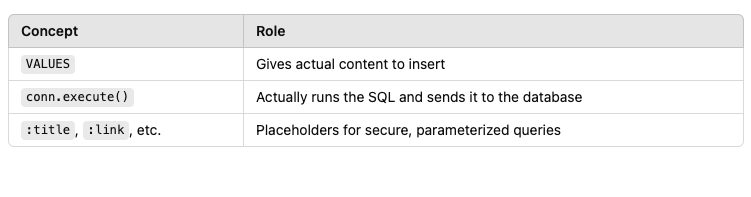

In [12]:
# example

# insert_article(
#     engine,
#     title="Bitcoin rebounds again",
#     link="https://www.ft.com/content/example",
#     snippet="The cryptocurrency is back in the green...",
#     date="2025-03-26"
# )

engine.connect vs engine.begin
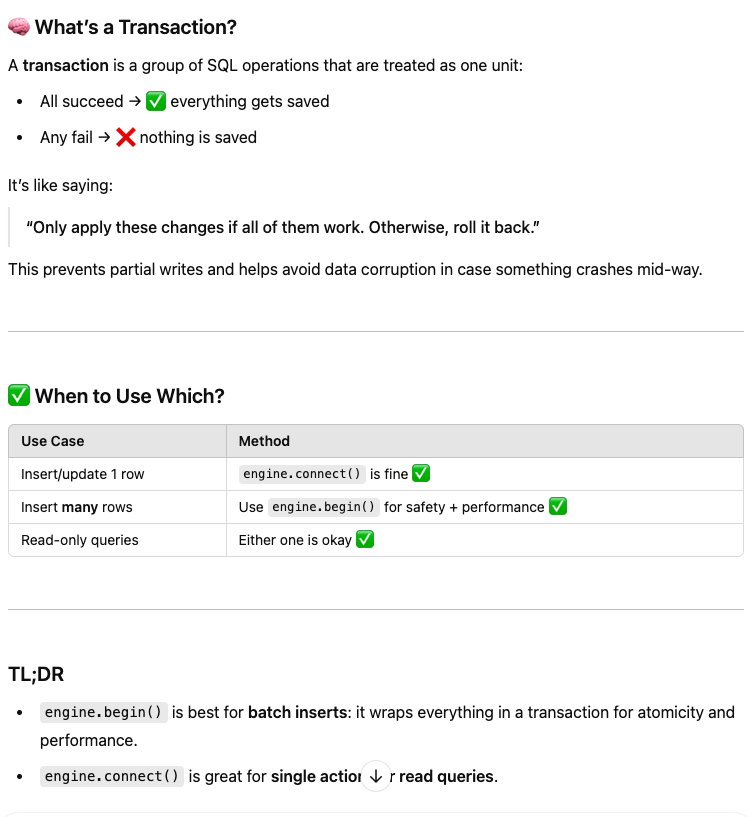

## Insert Multiple Rows (List of Dicts)
This is great for inserting a batch of rows from a DataFrame or scraped data:

In [ ]:
def insert_articles_bulk(engine, articles):
    """
    articles = list of dictionaries, e.g.
    [
        {"title": ..., "link": ..., "snippet": ..., "date": ...},
        ...
    ]
    """
    query = text("""
        INSERT INTO ft_articles (title, link, snippet, date)
        VALUES (:title, :link, :snippet, :date)
    """)

    with engine.begin() as conn:
        conn.execute(query, articles)
        print(f"✅ Inserted {len(articles)} articles.")


In [ ]:
# Example usage 

# articles = [
#     {
#         "title": "Article A",
#         "link": "https://ft.com/a",
#         "snippet": "A snippet...",
#         "date": "2025-03-25"
#     },
#     {
#         "title": "Article B",
#         "link": "https://ft.com/b",
#         "snippet": "B snippet...",
#         "date": "2025-03-26"
#     }
# ]

# insert_articles_bulk(engine, articles)


In [ ]:
# FROM Pandas  (If using Pandas and want to insert all rows from a DataFrame)

# insert_articles_bulk(engine, df.to_dict(orient="records"))


# Dealing with duplicates

In [15]:
# filtering
filtered_df = api_all_crypto[["date", "symbol", "close"]]

In [19]:
#chceking for duplicates
duplicates = filtered_df.groupby(["date","symbol"]).size().reset_index(name="count")
duplicates = duplicates[duplicates["count"]>1]


In [26]:
filtered_df

,date,symbol,close
0,2025-03-27,BTC,81173.54
1,2025-03-26,BTC,80976.04
2,2025-03-25,BTC,81040.50
3,2025-03-24,BTC,81016.58
4,2025-03-23,BTC,79452.90
...,...,...,...
1745,2024-04-16,SOL,128.38
1746,2024-04-15,SOL,130.54
1747,2024-04-14,SOL,142.48
1748,2024-04-13,SOL,132.12


In [52]:
pivot_df = filtered_df.pivot(index = "date", columns="symbol", values="close")

In [53]:
pivot_df

symbol,BTC,ETH,SOL,USDT,XRP
date,,,,,
2024-04-12,63328.63,3057.62,145.02,0.94460,0.5163
2024-04-13,61007.42,2870.80,132.12,0.95445,0.4578
2024-04-14,61867.60,2971.05,142.48,0.94176,0.4738
2024-04-15,59747.50,2921.33,130.54,0.94171,0.4689
2024-04-16,60117.86,2906.68,128.38,0.94230,0.4679
...,...,...,...,...,...
2025-03-23,79452.90,1849.98,122.47,0.92300,2.2517
2025-03-24,81016.58,1926.99,130.58,0.92597,2.2686
2025-03-25,81040.50,1915.72,133.22,0.92717,2.2712


<Axes: xlabel='date'>

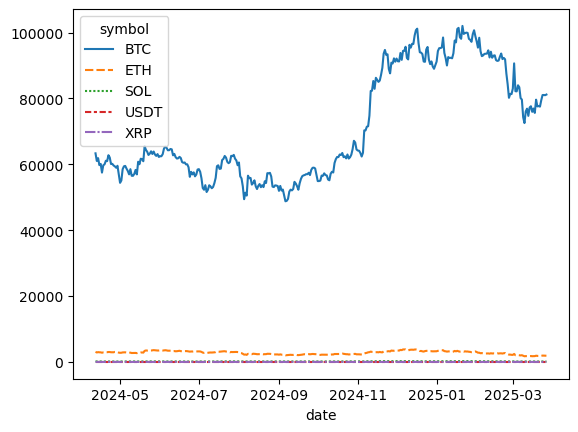

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=pivot_df)
# pivot_df.plot(figsize=(1
# 
# 
# 2,